In [ ]:
%pip install --upgrade diffusers[torch] -q
%pip install -U autotrain-advanced gradio

In [1]:
from diffusers import DiffusionPipeline, AutoencoderKL
import torch

vae = AutoencoderKL.from_pretrained(
    "madebyollin/sdxl-vae-fp16-fix", 
    torch_dtype=torch.float16
)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
)
pipe.to("cuda");

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [2]:
prompt = "MS dhoni running a marathon"

image = pipe(prompt=prompt, num_inference_steps=25, num_images_per_prompt = 2)

  0%|          | 0/25 [00:00<?, ?it/s]

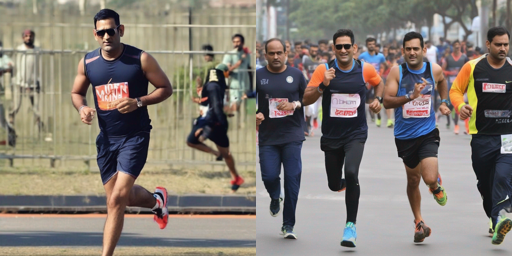

In [4]:
image_grid(image.images, 1, 2)

In [5]:
image.images[0].save('rawsdxl.jpg')

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

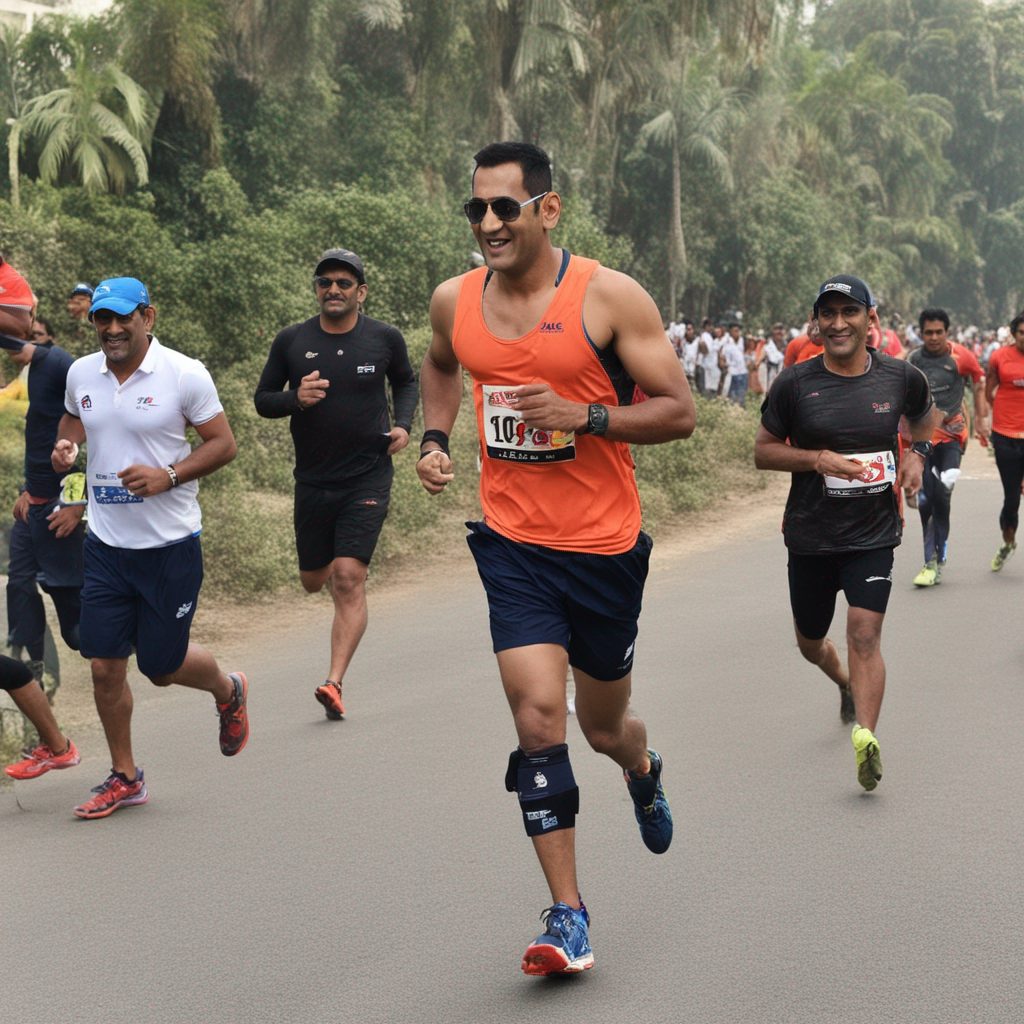

In [6]:
refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
refiner.to("cuda")

n_steps = 40
high_noise_frac = 0.7

image = pipe(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_end=high_noise_frac,
    output_type="latent",
).images

image = refiner(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_start=high_noise_frac,
    image=image,
).images[0]

image


In [7]:
image.save('refiner+sdxl.jpg')

In [ ]:
PROJECT_NAME = "darrendsouza"
MODEL_NAME = "stabilityai/stable-diffusion-xl-base-1.0"
DATA_DIR = "/kaggle/input/aliabhatt-pics"
REPO_ID = "Darren47"

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
HF_TOKEN = user_secrets.get_secret("HUGGINGFACE_TOKEN")

In [3]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]

    w, h = imgs[0].size
    grid_w, grid_h = cols * w, rows * h
    grid = Image.new("RGB", size=(grid_w, grid_h))

    for i, img in enumerate(imgs):
        x = i % cols * w
        y = i // cols * h
        grid.paste(img, box=(x, y))

    return grid

import glob

In [ ]:
imgs = [Image.open(path) for path in glob.glob("/kaggle/input/aliabhatt-pics/*.jpg")]
image_grid(imgs, 1, 4)

In [ ]:
!autotrain dreambooth \
--model $MODEL_NAME \
--project-name $PROJECT_NAME \
--image-path $DATA_DIR \
--prompt "Photos of Alia bhatt with various outfits and poses" \
--resolution 1024 \
--batch-size 1 \
--num-steps 200 \
--gradient-accumulation 4 \
--lr 1e-4 \
--mixed-precision "fp16" \
--push-to-hub \
--token $HF_TOKEN \
--username $REPO_ID

In [ ]:
from diffusers import DiffusionPipeline, AutoencoderKL, StableDiffusionXLImg2ImgPipeline

import torch

vae = AutoencoderKL.from_pretrained(
    "madebyollin/sdxl-vae-fp16-fix", 
    torch_dtype=torch.float16
)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
)
pipe.to("cuda");
pipe.load_lora_weights('Darren47/darrendsouza',weight_name="pytorch_lora_weights.safetensors")


prompt = "Alia bhatt running a marathon"

seed = 65
generator = torch.Generator("cuda").manual_seed(seed)
image = pipe(prompt=prompt, num_inference_steps=25,generator=generator).images[0]
image

In [ ]:
prompt = "A photo of MS dhoni at an indian wedding"

image = pipe(prompt=prompt, num_inference_steps=25, num_images_per_prompt = 3)
image_grid(image.images, 1, 3)

In [ ]:
generator = torch.Generator("cuda").manual_seed(seed)

In [ ]:
prompt = "A photo of MS dhoni in a spacesuit"

seed = 65
generator = torch.Generator("cuda").manual_seed(seed)
image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image.resize((300, 300))